# Test Preprocessing Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from urllib import request

from snxform import io, preproc

## Download a DESI EDR File

The DESI EDR data are available from a [public folder at NERSC](https://data.desi.lbl.gov/public/edr/).

We want the "cumulative" spectrum files labeled "spectra" in the `redux` folder, because these are not coadded across multiple nights of data taking.

In [2]:
if not os.path.exists('spectra-4-96-thru20210417.fits'):
    request.urlretrieve('https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles/cumulative/96/20210417/spectra-4-96-thru20210417.fits',
                        'spectra-4-96-thru20210417.fits')

## Read Spectra and Apply Target Selection

We'll use the `snxform.io` library to read in a FITS file, coadd the data across all spectrographs, and apply some target selection. A `desispec.spectra.Spectra` object is returned. Note that this isn't strictly necessary as the HDUs can be accessed directly, but the `Spectra` nicely encapsulates the data and headers in the file.

In [3]:
cspectra = io.read_desi_spectra('spectra-4-96-thru20210417.fits')

INFO:spectra.py:391:read_spectra: iotime 0.240 sec to read spectra-4-96-thru20210417.fits at 2024-05-18T08:49:25.589793


The target selection in `snxform.io.read_desi_spectra` keeps only targets that:
- Are not sky fibers.
- Have a good `FIBERSTATUS`.
- Have the `BGS_ANY` flag set in the `*_DESI_TARGET` bitmask.

For more details on the DESI bitmasks, [see the EDR documentation](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

In [4]:
#- Extract the data
wave = cspectra.wave['brz']
flux = cspectra.flux['brz']
ivar = cspectra.ivar['brz']

fmap = cspectra.fibermap
expfmap = cspectra.exp_fibermap

### Check FIBERMAP and EXP_FIBERMAP Tables

The `FIBERMAP` table contains target selection bits useful for grabbing objects from the different DESI sub-surveys.

The `EXP_FIBERMAP` includes status bits from a particular exposure, allowing for the rejection of poor observations.

In [5]:
fmap

TARGETID,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD
int64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64
39633424641687858,0,187.77737758325446,63.14422109382498,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.9287469238068996,516,9011,1880p632,626452,306,SER,0.013721436,21.75702,38.88969,56.977123,39.039074,26.96574,75.41751,23.239096,7.6066465,2.811201,0.88649076,3.19981,5.719516,8.379639,3.1998134,5.7195196,8.379639,0,1.498592,2.2791378,-0.18811049,-0.06277934,0,,0.0,0.0,0.0,0.0,N,102100,9,1152921504606846976,514,0,0,0,0,0,187.77737758325446,63.14422109382498,1,324.9099,1,1,0.024,0.024,-0.016,0.016,0.6461359,187.77758348029602,0.0,63.144287078322954,0.0,59322.27921731,59322.27921731,59322.27921731
39633419117792677,0,187.55475647332776,62.78109394602916,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.11400118587972086,516,9011,1873p627,625135,3493,REX,0.013696821,7.810925,23.30626,46.385456,102.13027,78.02947,120.01243,32.151943,10.168861,2.301354,0.84845895,1.187318,3.5427225,7.05093,1.1922137,3.554364,7.0551796,0,1.0,1.6390051,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,102100,3,1152921504606846976,514,0,0,0,0,0,187.55475647332776,62.78109394602916,1,324.9099,1,1,0.014,0.014,-0.019,0.019,0.6882743,187.5548744390062,0.0,62.78117117637362,0.0,59322.27921731,59322.27921731,59322.27921731
39633421894419617,0,187.85074855237858,63.121319692334474,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.9635660142945435,516,9011,1879p630,625797,1185,REX,0.013548589,3.0088878,11.595685,24.416233,24.08912,12.074717,457.56406,134.62872,33.841328,3.9301932,1.2206005,1.525837,5.8802876,12.381715,1.5323585,5.8896403,12.392047,0,1.0,0.5087386,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,102000,9,1152921504606846976,257,0,0,0,0,0,187.85074855237858,63.121319692334474,1,324.9099,1,1,0.019,0.019,-0.018,0.018,0.7414595,187.850912275342,0.0,63.121392003647365,0.0,59322.27921731,59322.27921731,59322.27921731
39633421894418839,0,187.72758172988506,63.04781135016675,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.8919834180454523,516,9011,1879p630,625797,407,REX,0.013608604,6.64939,10.922529,12.605876,9.69204,8.010322,241.0086,87.32799,31.519974,4.612006,1.2648023,2.817518,4.6281576,5.3414345,2.817518,4.6281576,5.3414345,0,1.0,0.6510797,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,102000,9,1152921504606846976,257,0,0,0,0,0,187.72758172988506,63.04781135016675,1,324.9099,1,1,0.018,0.018,-0.021,0.021,0.722592,187.72773606756562,0.0,63.04789544878099,0.0,59322.27921731,59322.27921731,59322.27921731
39633421894418723,0,187.70750799832473,63.031103897047714,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.7297535172097291,516,9011,1879p630,625797,291,SER,0.0137256915,7.549559,26.675716,52.13599,56.156437,39.629814,208.70312,57.21341,24.084879,2.9515135,0.99342024,3.035509,10.

In [6]:
expfmap

TARGETID,PRIORITY,SUBPRIORITY,NIGHT,EXPID,MJD,TILEID,EXPTIME,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,FIBERASSIGN_X,FIBERASSIGN_Y,LAMBDA_REF,PLATE_RA,PLATE_DEC,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,PSF_TO_FIBER_SPECFLUX,IN_COADD_B,IN_COADD_R,IN_COADD_Z
int64,int32,float64,int32,int32,float64,int32,float64,int16,int32,int64,int32,int32,float32,float32,float32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool
39633424641687858,102100,0.9287469238068996,20210417,85196,59322.27921731,96,324.9099,4,506,4506,2022,0,218.78717,325.8638,5400.0,187.77737758325446,63.14422109382498,2,218.719,325.833,0.024,-0.016,187.77758348029602,63.144287078322954,0.6461359137377224,True,True,True
39633419117792677,2,0.11400118587972086,20210417,85196,59322.27921731,96,324.9099,4,316,4316,2023,0,244.72704,232.50157,5400.0,187.55475647332776,62.78109394602916,2,244.677,232.494,0.014,-0.019,187.55487443900614,62.78117117637362,0.6882743292378964,True,True,True
39633421894419617,102000,0.9635660142945435,20210417,85196,59322.27921731,96,324.9099,4,490,4490,2032,0,210.15402,319.2097,5400.0,187.85074855237858,63.121319692334474,2,210.094,319.18,0.019,-0.018,187.850912275342,63.121392003647365,0.7414594775877278,True,True,True
39633421894418839,102000,0.8919834180454523,20210417,85196,59322.27921731,96,324.9099,4,470,4470,2034,0,224.46428,300.67065,5400.0,187.72758172988506,63.04781135016675,2,224.404,300.649,0.018,-0.021,187.72773606756564,63.04789544878099,0.7225919938829735,True,True,True
39633421894418723,102100,0.7297535172097291,20210417,85196,59322.27921731,96,324.9099,4,449,4449,2045,0,226.80005,296.41934,5400.0,187.70750799832473,63.031103897047714,2,226.737,296.395,0.021,-0.018,187.70768758479727,63.031177472883726,0.6874586103221126,True,True,True
39633419126178966,102000,0.5806068075223845,20210417,85196,59322.27921731,96,324.9099,4,249,4249,2050,0,156.34076,221.89372,5400.0,188.31348122239865,62.75709847382859,2,156.307,221.869,0.015,-0.005,188.3136116687766,62.757120423884984,0.7570511285698633,True,True,True
39633421898614556,102000,0.093359216937,20210417,85196,59322.27921731,96,324.9099,4,288,4288,2052,0,137.89766,253.51016,5400.0,188.4741242410771,62.88353644986568,2,137.863,253.489,0.015,-0.017,188.47425540728798,62.88360485127935,0.7548031326399618,True,True,True
39633419126179562,102000,0.347702875463072,20210417,85196,59322.27921731,96,324.9099,4,268,4268,2055,0,146.09883,238.40146,5400.0,188.40251147747335,62.8233891659526,2,146.064,238.379,0.015,-0.012,188.40264226367879,62.8234383725031,0.7145742100338675,True,True,True
39633421898613551,102100,0.449468640768493,20210417,85196,59322.27921731,96,324.9099,4,346,4346,2056,0,155.2833,270.57877,5400.0,188.32271527567775,62.94697989312816,2,155.243,270.555,0.016,-0.018,188.32285482355888,62.947052136073516,0.6941423767152336,True,True,True


## Remove Skylines and Rebin

Just some basic preprocessing to remove known skylines (primarily above 7000 angstroms) and rebin the spectrum to a common wavelength grid.

In [7]:
#- Clean sky lines and rebin.
newflux = preproc.remove_sky_lines(wave, flux, ivar)
newwave, newflux, newivar = preproc.rebin_flux(wave, newflux, ivar, nbins=3600)

#- Rescale the flux (not strictly necessary).
flux_rescaled = preproc.rescale_flux(newflux)

### Plots

Pick out a handful of bright objects and plot them.

In [8]:
idx = np.argwhere(np.in1d(fmap['TARGETID'], [39633416332774581, 39633410687239610, 39633424645884654, 39633421894421222])).flatten()

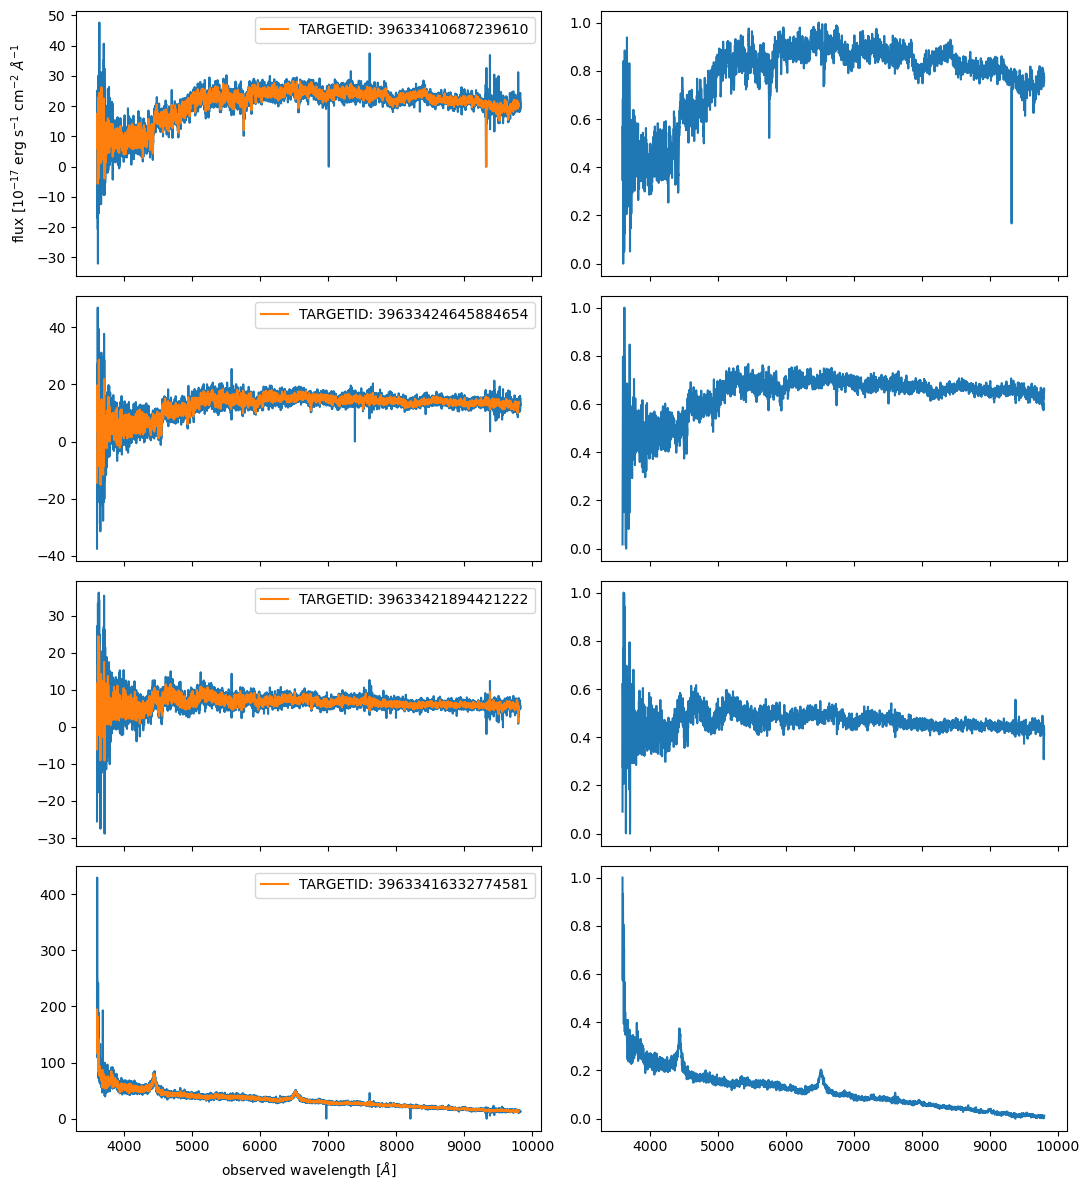

In [9]:
N = len(idx)

fig, axes = plt.subplots(N,2, figsize=(11,3*N), tight_layout=True, sharex=True)
for i in range(N):
    ax = axes[i][0]
    if i == 0:
        ax.set(ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
    j = idx[i]
    ax.plot(wave, flux[j])
    ax.plot(newwave, newflux[j], label=f'TARGETID: {fmap["TARGETID"][j]}')
    ax.legend(loc='best')

    if i == N-1:
        ax.set(xlabel=r'observed wavelength [$\AA$]')

    ax = axes[i][1]
    ax.plot(newwave, flux_rescaled[j])